# Análisis de datos genéticos de cáncer de seno
## Importación de librerías

In [1]:
import pandas as pd
import numpy as np
# import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer

import seaborn as sns
from sklearn import metrics

## Carga de datos

In [2]:
df = pd.read_csv('METABRIC_RNA_MUTATION.csv')

C:\Users\achav\AppData\Local\Temp\ipykernel_21460\1524619863.py:1: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('METABRIC_RNA_MUTATION.csv')


## Encabezado de la tabla

In [3]:
df.head()

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0


## Forma y columnas de los datos

In [4]:
print(df.shape)
print(df.columns)

(1904, 693)
Index(['patient_id', 'age_at_diagnosis', 'type_of_breast_surgery',
       'cancer_type', 'cancer_type_detailed', 'cellularity', 'chemotherapy',
       'pam50_+_claudin-low_subtype', 'cohort', 'er_status_measured_by_ihc',
       ...
       'mtap_mut', 'ppp2cb_mut', 'smarcd1_mut', 'nras_mut', 'ndfip1_mut',
       'hras_mut', 'prps2_mut', 'smarcb1_mut', 'stmn2_mut', 'siah1_mut'],
      dtype='object', length=693)


## Tipos de datos de cada columna

In [5]:
df.dtypes

patient_id                  int64
age_at_diagnosis          float64
type_of_breast_surgery     object
cancer_type                object
cancer_type_detailed       object
                           ...   
hras_mut                   object
prps2_mut                  object
smarcb1_mut                object
stmn2_mut                  object
siah1_mut                  object
Length: 693, dtype: object

## Algunas columnas muestran una alerta de diferentes tipos de datos

In [6]:
df.columns.values[[678, 688, 690, 692]]

array(['rasgef1b_mut', 'hras_mut', 'smarcb1_mut', 'siah1_mut'],
      dtype=object)

In [7]:
df[['rasgef1b_mut', 'hras_mut', 'smarcb1_mut', 'siah1_mut']].dtypes

rasgef1b_mut    object
hras_mut        object
smarcb1_mut     object
siah1_mut       object
dtype: object

## Descripcion de las variables con la alerta

In [8]:
df[['rasgef1b_mut', 'hras_mut', 'smarcb1_mut', 'siah1_mut']].describe()

,rasgef1b_mut,hras_mut,smarcb1_mut,siah1_mut
count,1904,1904,1904,1904
unique,9,4,4,3
top,0,0,0,0
freq,1024,1024,1024,1024


## Las variables con la alerta indican mutaciones en los genes correspondientes. 0 = no mutacion ; x = mutacion hay valores de 0 como caracter. Estas columnas habrá que binarizarlas.

In [9]:
print(df['rasgef1b_mut'].unique())
print(df['hras_mut'].unique())
print(df['smarcb1_mut'].unique())
print(df['siah1_mut'].unique())

[0 '0' 'V418A' 'S343G' 'R140Q' 'X2_splice' 'R353H' 'H396Y' 'E78K']
[0 '0' 'Q61R' 'N86T']
[0 '0' 'D159N' 'I28L']
[0 '0' 'T249A']


## Empezamos haciendo la conversión de '0' a 0 para todas las columnas donde había ambigüedad

In [10]:
df[['rasgef1b_mut', 'hras_mut', 'smarcb1_mut', 'siah1_mut']] = df[['rasgef1b_mut', 'hras_mut', 'smarcb1_mut', 'siah1_mut']].replace(['0'], 0)

In [11]:
print(df['rasgef1b_mut'].unique())
print(df['hras_mut'].unique())
print(df['smarcb1_mut'].unique())
print(df['siah1_mut'].unique())

[0 'V418A' 'S343G' 'R140Q' 'X2_splice' 'R353H' 'H396Y' 'E78K']
[0 'Q61R' 'N86T']
[0 'D159N' 'I28L']
[0 'T249A']


## Algoritmo de binarización aplicado a mutaciones

In [12]:
for mut in df['rasgef1b_mut'].unique():
    if mut != 0:
        column = df['rasgef1b_mut'] == mut
        column = column.replace([False], 0).replace([True],1)
        df[mut] = column

## Histograma de edad de diagnóstico

(array([ 10.,  54., 159., 265., 315., 389., 379., 237.,  86.,  10.]),
 array([21.93 , 29.366, 36.802, 44.238, 51.674, 59.11 , 66.546, 73.982,
        81.418, 88.854, 96.29 ]),
 <BarContainer object of 10 artists>)

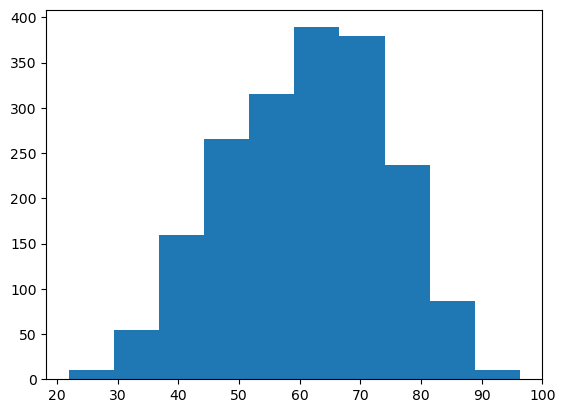

In [13]:
plt.hist(df['age_at_diagnosis'])

## Descripción de edad de diagnóstico

In [14]:
df['age_at_diagnosis'].describe()

count    1904.000000
mean       61.087054
std        12.978711
min        21.930000
25%        51.375000
50%        61.770000
75%        70.592500
max        96.290000
Name: age_at_diagnosis, dtype: float64

## Conteo de valores de las variables no genéticas

In [15]:
for i in range(2,31):
    print(i, df.columns[i])
    value_counts = df.iloc[:,i].value_counts()
    nan = df.iloc[:,i].isna().sum()
    print(value_counts)
    print('nans:',nan, '\n')

2 type_of_breast_surgery
MASTECTOMY           1127
BREAST CONSERVING     755
Name: type_of_breast_surgery, dtype: int64
nans: 22 

3 cancer_type
Breast Cancer     1903
Breast Sarcoma       1
Name: cancer_type, dtype: int64
nans: 0 

4 cancer_type_detailed
Breast Invasive Ductal Carcinoma             1500
Breast Mixed Ductal and Lobular Carcinoma     207
Breast Invasive Lobular Carcinoma             142
Breast Invasive Mixed Mucinous Carcinoma       22
Breast                                         17
Metaplastic Breast Cancer                       1
Name: cancer_type_detailed, dtype: int64
nans: 15 

5 cellularity
High        939
Moderate    711
Low         200
Name: cellularity, dtype: int64
nans: 54 

6 chemotherapy
0    1508
1     396
Name: chemotherapy, dtype: int64
nans: 0 

7 pam50_+_claudin-low_subtype
LumA           679
LumB           461
Her2           220
claudin-low    199
Basal          199
Normal         140
NC               6
Name: pam50_+_claudin-low_subtype, dtype: int6

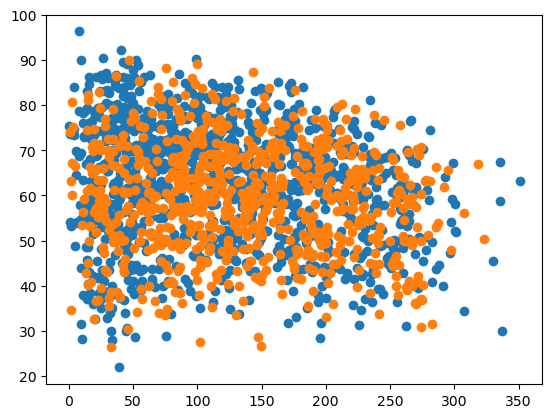

In [16]:
x1 = df.overall_survival_months[df.type_of_breast_surgery == 'MASTECTOMY']
y1 = df.age_at_diagnosis[df.type_of_breast_surgery == 'MASTECTOMY']

x2 = df.overall_survival_months[df.type_of_breast_surgery == 'BREAST CONSERVING']
y2 = df.age_at_diagnosis[df.type_of_breast_surgery == 'BREAST CONSERVING']

plt.scatter(x1, y1)
plt.scatter(x2, y2)

## Aplicando las técnicas de IA

### Regresión logística aplicada a la supervivencia en función del perfil genético

Text(0.5, 0.98, 'Confusion matrices for overall survival classification')

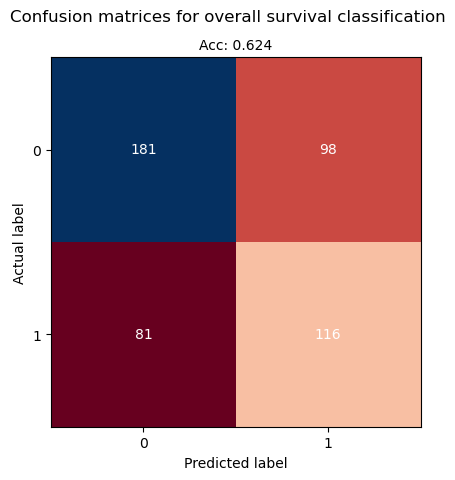

In [108]:
train_dataset = df.sample(frac=0.75, random_state=1)
test_dataset = df.drop(train_dataset.index)

max_iter = 1000
log_reg = LogisticRegression(multi_class='multinomial', max_iter=max_iter)
x_train = train_dataset.loc[:,'brca1':'ugt2b7']
x_test = test_dataset.loc[:,'brca1':'ugt2b7']

log_reg.fit(x_train, train_dataset['overall_survival'])
predictions = log_reg.predict(x_test)
score = log_reg.score(x_test, test_dataset['overall_survival'])
# print(score)
cm = metrics.confusion_matrix(test_dataset['overall_survival'], predictions)
# print(cm)

fig, axs = plt.subplots(1)
axs.imshow(cm, cmap="RdBu")
axs.set_title('{0}\nAcc: {1}'.format(cancer_type[0:-9] ,round(score,3)), fontsize = 10)
axs.set_xticks([0,1])
axs.set_yticks([0,1])
axs.set(xlabel='Predicted label', ylabel='Actual label')
for k in range(len(cm)):
        for j in range(len(cm)):
            text = axs.text(j, k, cm[k, j],
                           ha="center", va="center", color="w")
fig.suptitle('Confusion matrices for overall survival classification')


### Regresión logística aplicada para clasificar tipos de cáncer en función del perfil genético

In [112]:
train_dataset = df.dropna().sample(frac=0.75, random_state=1)
test_dataset = df.drop(train_dataset.index).dropna()

x_train, y_train = train_dataset.loc[:,'brca1':'ugt2b7'], train_dataset['overall_survival']
x_test, y_test = test_dataset.loc[:,'brca1':'ugt2b7'], test_dataset['overall_survival']

#### Binarización de los tipos de cáncer

In [113]:
print(test_dataset['cancer_type_detailed'].unique())
y_train = pd.get_dummies(train_dataset['cancer_type_detailed'])
y_test = pd.get_dummies(test_dataset['cancer_type_detailed'])

['Breast Invasive Lobular Carcinoma' 'Breast Invasive Ductal Carcinoma'
 'Breast Mixed Ductal and Lobular Carcinoma'
 'Breast Invasive Mixed Mucinous Carcinoma' 'Breast']


#### Tamaño de los sets de entrenamiento y prueba

In [114]:
print(len(train_dataset))
print(len(test_dataset))

819
273


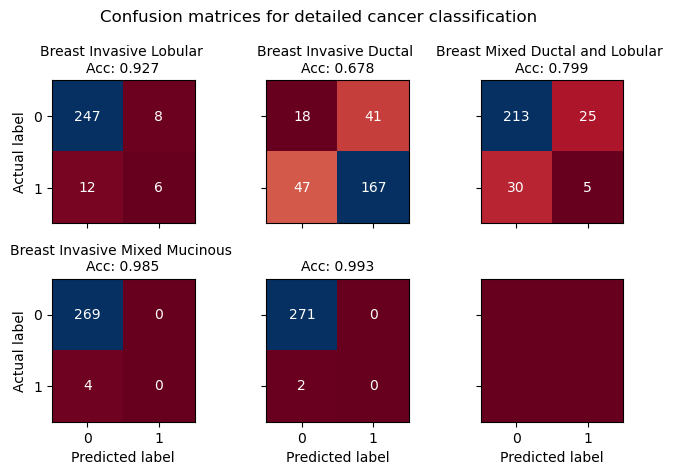

In [115]:
max_iter = 1000
log_reg = LogisticRegression(multi_class='multinomial', max_iter=max_iter)
x_train = train_dataset.loc[:,'brca1':'ugt2b7']
x_test = test_dataset.loc[:,'brca1':'ugt2b7']

fig, axs = plt.subplots(2, 3)

for i, cancer_type in enumerate(test_dataset['cancer_type_detailed'].dropna().unique()):
    # print(cancer_type)
    # print(y_test[cancer_type].value_counts())
    log_reg.fit(x_train, y_train[cancer_type])
    predictions = log_reg.predict(x_test)
    score = log_reg.score(x_test, y_test[cancer_type])
    # print(score)
    cm = metrics.confusion_matrix(y_test[cancer_type], predictions)
    # print(cm)
    # print("*"*50)

    axs[int(i/3), i%3].imshow(cm, cmap="RdBu")
    axs[int(i/3), i%3].set_title('{0}\nAcc: {1}'.format(cancer_type[0:-9] ,round(score,3)), fontsize = 10)
    axs[int(i/3), i%3].set_xticks([0,1])
    axs[int(i/3), i%3].set_yticks([0,1])
    
    for k in range(len(cm)):
        for j in range(len(cm)):
            text = axs[int(i/3), i%3].text(j, k, cm[k, j],
                           ha="center", va="center", color="w")
    
    for ax in axs.flat:
        ax.set(xlabel='Predicted label', ylabel='Actual label')
        ax.label_outer()

axs[1, 2].imshow(np.array([[0,0],[0,0]]) , cmap="RdBu")
axs[1, 2].set_xticks([0,1])
axs[1, 2].set_yticks([0,1])
fig.suptitle('Confusion matrices for detailed cancer classification')
fig.tight_layout()
fig.subplots_adjust(wspace=0.5)

In [116]:
from sklearn.ensemble import RandomForestClassifier

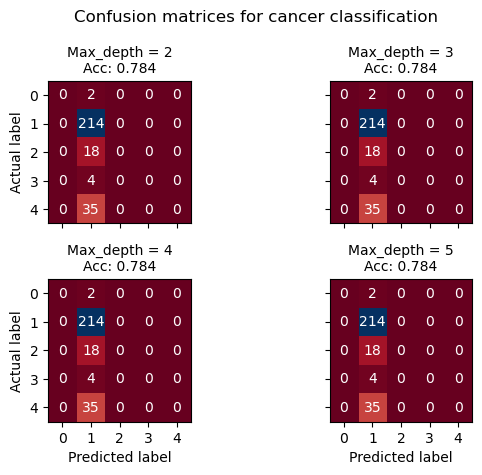

In [199]:

score = []
score_train = []
fig, axs = plt.subplots(2, 2)

for i in range(2,6):
    clf = RandomForestClassifier(max_depth=i, random_state=0)
    clf.fit(x_train, train_dataset['cancer_type_detailed'])
    
    score_train.append(clf.score(x_train, train_dataset['cancer_type_detailed']))
    score.append(clf.score(x_test, test_dataset['cancer_type_detailed']))
    predictions = clf.predict(x_test)
    
    # print(clf.classes_)
    # print(clf.feature_importances_)
    cm = metrics.confusion_matrix(test_dataset['cancer_type_detailed'], predictions)
    # print(cm)
    axs[int((i-2)/2), i%2].imshow(cm, cmap="RdBu")
    axs[int((i-2)/2), i%2].set_title('Max_depth = {0}\nAcc: {1}'.format(i ,round(score[i-2] ,3)), fontsize = 10)
    axs[int((i-2)/2), i%2].set_xticks(range(0,5))
    axs[int((i-2)/2), i%2].set_yticks(range(0,5))
    
    for k in range(len(cm)):
        for j in range(len(cm)):
            text = axs[int((i-2)/2), i%2].text(j, k, cm[k, j],
                           ha="center", va="center", color="w")
    
    for ax in axs.flat:
        ax.set(xlabel='Predicted label', ylabel='Actual label')
        ax.label_outer()
    
fig.suptitle('Confusion matrices for cancer classification')
fig.tight_layout()

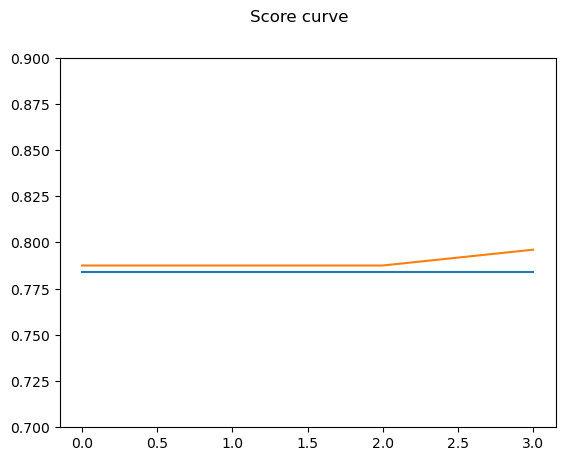

Mejor desempeño con el conjunto de pruebas:  0.7838827838827839


In [152]:
f, ax = plt.subplots(1)
ax.plot(score)
ax.plot(score_train)
ax.set_ylim(ymin=0.7, ymax=0.9)
f.suptitle("Score curve")
plt.show(f)
print("Mejor desempeño con el conjunto de pruebas: ", max(score))

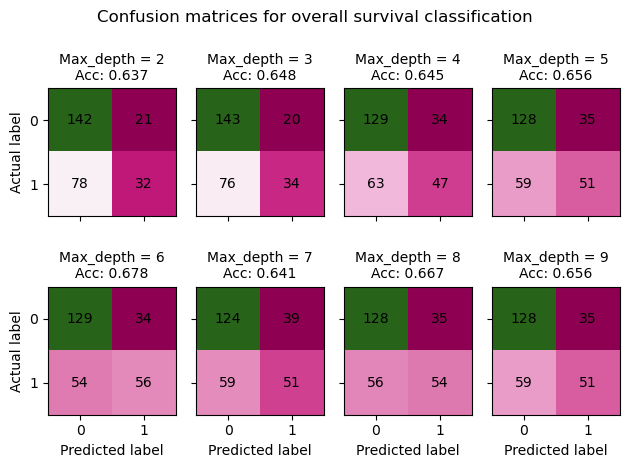

In [196]:
clf = RandomForestClassifier(max_depth=6)
clf.fit(x_train, y_train)
clf.score(x_test, y_test)
score_train = []
score_test = []

fig, axs = plt.subplots(2, 4)

for i in range(2,10):
    clf = RandomForestClassifier(max_depth=i, random_state=0)
    clf.fit(x_train, train_dataset['overall_survival'])
    predictions = clf.predict(x_test)
    score_train.append(clf.score(x_train, train_dataset['overall_survival']))
    score_test.append(clf.score(x_test, test_dataset['overall_survival']))
    # print(clf.feature_importances_)
    cm = metrics.confusion_matrix(test_dataset['overall_survival'], predictions)

    axs[int((i-2)/4), (i-2)%4].imshow(cm, cmap="PiYG")
    axs[int((i-2)/4), (i-2)%4].set_title('Max_depth = {0}\nAcc: {1}'.format(i ,round(score_test[i-2] ,3)), fontsize = 10)
    axs[int((i-2)/4), (i-2)%4].set_xticks([0,1])
    axs[int((i-2)/4), (i-2)%4].set_yticks([0,1])
    
    for k in range(len(cm)):
        for j in range(len(cm)):
            text = axs[int((i-2)/4), (i-2)%4].text(j, k, cm[k, j],
                           ha="center", va="center", color="black")
    
    for ax in axs.flat:
        ax.set(xlabel='Predicted label', ylabel='Actual label')
        ax.label_outer()

fig.suptitle('Confusion matrices for overall survival classification')
fig.tight_layout()

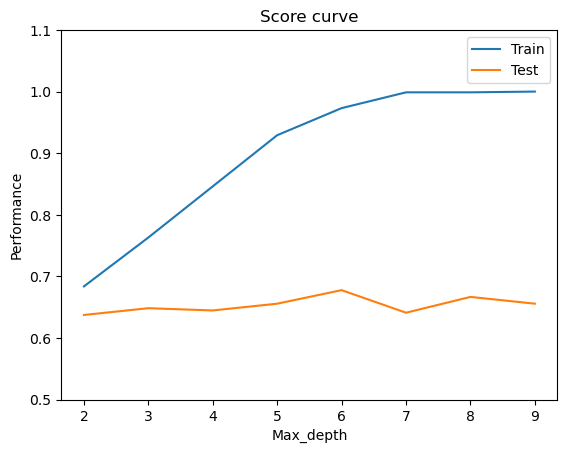

Mejor desempeño con el conjunto de pruebas: 0.678 con un árbol de profundidad 6


In [195]:
f, ax = plt.subplots(1)
ax.plot(range(2,10), score_train)
ax.plot(range(2,10), score_test)
ax.set_ylim(ymin=0.5, ymax=1.1)
ax.set_title("Score curve")
ax.set(xlabel='Max_depth', ylabel='Performance')
ax.legend(["Train", "Test"], loc="upper right")

plt.show(f)
print("Mejor desempeño con el conjunto de pruebas: {0} con un árbol de profundidad {1}".format(round(max(score_test),3), score_test.index(max(score_test))+2))